<span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">Image Colorization using GANs 🧨</h1></span> 

In this notebook you'll learn to implement GANs, unets, and realize how pretraining is used in improve the model performance.
This notebook tackles the task of image colorization using conditional GANs. The implementation is inspired from pix2pix paper.
# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">Intro: Generative Adversarial Networks 🍭<a id="Intro"></a></h1></span>
This module contains brief introduction to GANs. Feel free to skip it if you're familiar with it.

A GAN model comprises of 2 sub-models:

* The <b>generator</b> learns to generate plausible data. The generated instances become negative training examples for the discriminator.
* The <b>discriminator</b> learns to distinguish the generator's fake data from real data. The discriminator penalizes the generator for producing implausible results.

We simultaneously train two models: a generative model G that captures the data distribution, and a discriminative model D that estimates
the probability that a sample came from the training data rather than G. The training procedure for G is to maximize the probability of D making a mistake. This framework corresponds to a minimax two-player game. In the space of arbitrary functions G and D, a unique solution exists, with G recovering the training data distribution and D equal to ${1 \over 2}$ everywhere. 


<img src="https://media.springernature.com/full/springer-static/image/art%3A10.1038%2Fs41524-020-00352-0/MediaObjects/41524_2020_352_Fig1_HTML.png" width="800"></img>


# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">Install Required Libraries 📦 <a id="Installing required libraries"></a></h1></span>

In [1]:
!pip install torchsummary

# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">Import Required Libraries 🧺<a id="Importing libraries"></a></h1></span>

### 1.1- Loading Image Paths

In [2]:
import os
import glob
import time

# For data manipulation
import numpy as np
from PIL import Image
import cv2 as cv
from pathlib import Path

# Pytorch imports
import torch
from torch import nn, optim
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader
import torchsummary
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Utils
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from skimage.color import rgb2lab, lab2rgb

In [3]:
# !pip install fastai==2.4
from fastai.vision.learner import create_body
from torchvision.models.resnet import resnet18
from fastai.vision.models.unet import DynamicUnet

# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">Making Dataset and Dataloaders🥡<a id="Datasets and Dataloaders"></a></h1></span>
We'll be using a subset of <b>COCO dataset</b>: 8000 training images and 2000 validation images.

In [4]:
# setting seed
np.random.seed(123)

paths = glob.glob('/kaggle/input/coco-2017-dataset/coco2017/train2017' + "/*.jpg") # Grabbing all the image file paths
paths_subset = np.random.choice(paths, 10_000, replace=False) # choosing 10000 paths randomly
rand_idxs = np.random.permutation(10_000) # generate a numpy array of numbers from 0 to 9999 in any random order
train_idxs = rand_idxs[:8000]
val_idxs = rand_idxs[8000:]
train_paths = paths_subset[train_idxs]
val_paths = paths_subset[val_idxs]

print("Number of training images: ",len(train_paths))
print("Number of testing images: ",len(val_paths))

Number of training images:  8000
Number of testing images:  2000


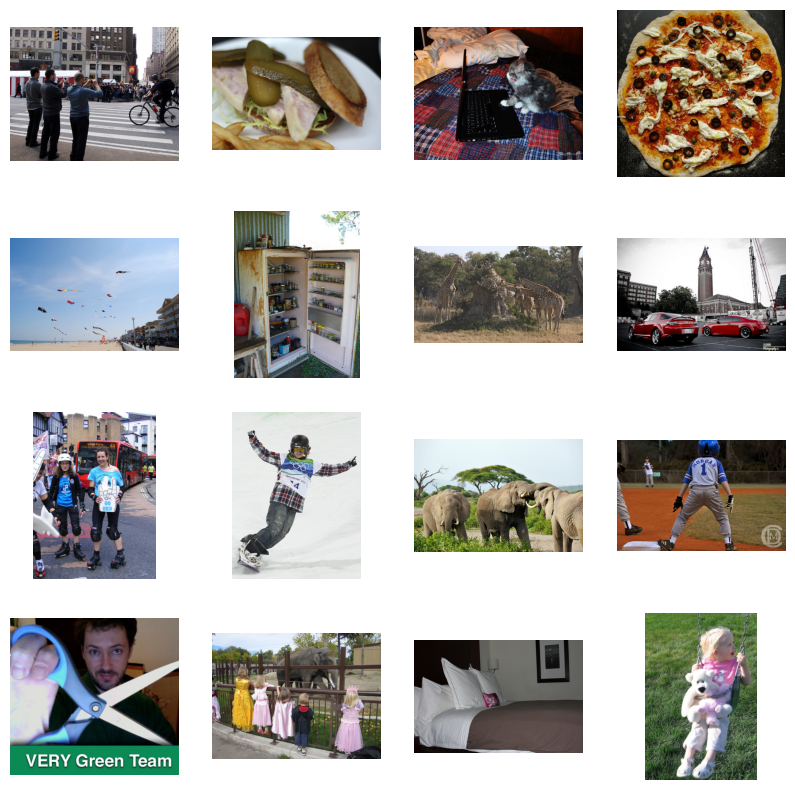

In [5]:
# Visualizing the dataset
_, axes = plt.subplots(4, 4, figsize=(10, 10))
for ax, img_path in zip(axes.flatten(), train_paths):
    ax.imshow(Image.open(img_path))
    ax.axis("off")

In [6]:
SIZE = 256
class ColorizationDataset(Dataset):
    def __init__(self, paths, split='train'):
        if split == 'train':
            self.transforms = transforms.Compose([
                transforms.Resize((SIZE, SIZE),  Image.BICUBIC),
                transforms.RandomHorizontalFlip(), # A little data augmentation!
            ])
        elif split == 'val':
            self.transforms = transforms.Resize((SIZE, SIZE),  Image.BICUBIC)
        
        self.split = split
        self.size = SIZE
        self.paths = paths
    
    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert("RGB")
        img = self.transforms(img)
        img = np.array(img)
        img_lab = rgb2lab(img).astype("float32") # Converting RGB to L*a*b
        img_lab = transforms.ToTensor()(img_lab)
        L = img_lab[[0], ...] / 50. - 1. # Between -1 and 1
        ab = img_lab[[1, 2], ...] / 110. # Between -1 and 1
        
        return {'L': L, 'ab': ab}
    
    def __len__(self):
        return len(self.paths)

def make_dataloaders(batch_size=16, n_workers=2, pin_memory=True, **kwargs): # A handy function to make our dataloaders
    dataset = ColorizationDataset(**kwargs)
    dataloader = DataLoader(dataset, batch_size=batch_size, num_workers=n_workers,
                            pin_memory=pin_memory)
    return dataloader

In [7]:
train_dl = make_dataloaders(paths=train_paths, split='train')
val_dl = make_dataloaders(paths=val_paths, split='val')
print("Number of training batches: ",len(train_paths)) # 8000 / dataloader_batch_size(=16)
print("Number of testing batches: ",len(val_paths)) # 2000 / 16
data = next(iter(train_dl))
Ls, abs_ = data['L'], data['ab']
print(Ls.shape, abs_.shape)

Number of training batches:  8000
Number of testing batches:  2000
torch.Size([16, 1, 256, 256]) torch.Size([16, 2, 256, 256])


# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">Generator✨<a id="Model Architecture"></a></h1></span>

![unet](https://raw.githubusercontent.com/prabhanjan-jadhav/image-colorization-using-gans/main/images/UNet%20architechture.png)

In [8]:
class UnetBlock(nn.Module):
    def __init__(self, nf, ni, submodule=None, input_c=None, dropout=False,
                 innermost=False, outermost=False):
        super().__init__()
        self.outermost = outermost
        if input_c is None: input_c = nf
        downconv = nn.Conv2d(input_c, ni, kernel_size=4,
                             stride=2, padding=1, bias=False)
        downrelu = nn.LeakyReLU(0.2, True)
        downnorm = nn.BatchNorm2d(ni)
        uprelu = nn.ReLU(True)
        upnorm = nn.BatchNorm2d(nf)
        
        if outermost:
            upconv = nn.ConvTranspose2d(ni * 2, nf, kernel_size=4,
                                        stride=2, padding=1)
            down = [downconv]
            up = [uprelu, upconv, nn.Tanh()]
            model = down + [submodule] + up
        elif innermost:
            upconv = nn.ConvTranspose2d(ni, nf, kernel_size=4,
                                        stride=2, padding=1, bias=False)
            down = [downrelu, downconv]
            up = [uprelu, upconv, upnorm]
            model = down + up
        else:
            upconv = nn.ConvTranspose2d(ni * 2, nf, kernel_size=4,
                                        stride=2, padding=1, bias=False)
            down = [downrelu, downconv, downnorm]
            up = [uprelu, upconv, upnorm]
            if dropout: up += [nn.Dropout(0.5)]
            model = down + [submodule] + up
        self.model = nn.Sequential(*model)
    
    def forward(self, x):
        if self.outermost:
            return self.model(x)
        else:
            return torch.cat([x, self.model(x)], 1)

class Unet(nn.Module):
    def __init__(self, input_c=1, output_c=2, n_down=8, num_filters=64):
        super().__init__()
        unet_block = UnetBlock(num_filters * 8, num_filters * 8, innermost=True)
        for _ in range(n_down - 5):
            unet_block = UnetBlock(num_filters * 8, num_filters * 8, submodule=unet_block, dropout=True)
        out_filters = num_filters * 8
        for _ in range(3):
            unet_block = UnetBlock(out_filters // 2, out_filters, submodule=unet_block)
            out_filters //= 2
        self.model = UnetBlock(output_c, out_filters, input_c=input_c, submodule=unet_block, outermost=True)
    
    def forward(self, x):
        return self.model(x)

In [9]:
torchsummary.summary(Unet(), input_size=(1,256,256),batch_size=1)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [1, 64, 128, 128]           1,024
         LeakyReLU-2          [1, 64, 128, 128]               0
            Conv2d-3           [1, 128, 64, 64]         131,072
       BatchNorm2d-4           [1, 128, 64, 64]             256
         LeakyReLU-5           [1, 128, 64, 64]               0
            Conv2d-6           [1, 256, 32, 32]         524,288
       BatchNorm2d-7           [1, 256, 32, 32]             512
         LeakyReLU-8           [1, 256, 32, 32]               0
            Conv2d-9           [1, 512, 16, 16]       2,097,152
      BatchNorm2d-10           [1, 512, 16, 16]           1,024
        LeakyReLU-11           [1, 512, 16, 16]               0
           Conv2d-12             [1, 512, 8, 8]       4,194,304
      BatchNorm2d-13             [1, 512, 8, 8]           1,024
        LeakyReLU-14             [1, 51

# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">Discriminator </h1></span>

The architecture of our discriminator is rather straight forward. This code implements a model by stacking blocks of Conv-BatchNorm-LeackyReLU to decide whether the input image is fake or real. Notice that the first and last blocks do not use normalization and the last block has no activation function (it is embedded in the loss function we will use).

In [10]:
class PatchDiscriminator(nn.Module):
    def __init__(self, input_c, num_filters=64, n_down=3):
        super().__init__()
        model = [self.get_layers(input_c, num_filters, norm=False)]
        model += [self.get_layers(num_filters * 2 ** i, num_filters * 2 ** (i + 1), s=1 if i == (n_down-1) else 2) 
                          for i in range(n_down)] # the 'if' statement is taking care of not using
                                                  # stride of 2 for the last block in this loop
        model += [self.get_layers(num_filters * 2 ** n_down, 1, s=1, norm=False, act=False)] # Make sure to not use normalization or
                                                                                             # activation for the last layer of the model
        self.model = nn.Sequential(*model)                                                   
        
    def get_layers(self, ni, nf, k=4, s=2, p=1, norm=True, act=True): # when needing to make some repeatitive blocks of layers,
        layers = [nn.Conv2d(ni, nf, k, s, p, bias=not norm)]          # it's always helpful to make a separate method for that purpose
        if norm: layers += [nn.BatchNorm2d(nf)]
        if act: layers += [nn.LeakyReLU(0.2, True)]
        return nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

In [11]:
torchsummary.summary(PatchDiscriminator(3), input_size=(3, 194, 194),batch_size=16)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [16, 64, 97, 97]           3,136
         LeakyReLU-2           [16, 64, 97, 97]               0
            Conv2d-3          [16, 128, 48, 48]         131,072
       BatchNorm2d-4          [16, 128, 48, 48]             256
         LeakyReLU-5          [16, 128, 48, 48]               0
            Conv2d-6          [16, 256, 24, 24]         524,288
       BatchNorm2d-7          [16, 256, 24, 24]             512
         LeakyReLU-8          [16, 256, 24, 24]               0
            Conv2d-9          [16, 512, 23, 23]       2,097,152
      BatchNorm2d-10          [16, 512, 23, 23]           1,024
        LeakyReLU-11          [16, 512, 23, 23]               0
           Conv2d-12            [16, 1, 22, 22]           8,193
Total params: 2,765,633
Trainable params: 2,765,633
Non-trainable params: 0
---------------------------

# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">Loss Function 🧭<a id="Loss function"></a></h1></span>
* **Loss function we optimize** :
\begin{equation}
G^* = arg min_G max_D L_{cGAN} (G,D) + \lambda L_{L1} (G)
\end{equation}


* **L1 Loss** : 
\begin{equation}
L_{L1} (G) = \mathbb{E}_{x,y,z}[\|y-G(x,z)\|_1]
\end{equation}


* **GAN Loss** : 
\begin{equation}
L_{cGAN}(G,D) = \mathbb{E}_{x,y}[logD(x,y)] + \mathbb{E}_{x,z}[log(1-D(x, G(x,z))]
\end{equation}
Where **x** as the grayscale image, **z** as the input noise for the generator, and **y** as the 2-channel output we want from the generator (it can also represent the 2 color channels of a real image). Also, **G** is the generator model and **D** is the discriminator. 


In [12]:
class GANLoss(nn.Module):
    def __init__(self, gan_mode='vanilla', real_label=1.0, fake_label=0.0):
        super().__init__()
        self.register_buffer('real_label', torch.tensor(real_label))
        self.register_buffer('fake_label', torch.tensor(fake_label))
        if gan_mode == 'vanilla':
            self.loss = nn.BCEWithLogitsLoss()
        elif gan_mode == 'lsgan':
            self.loss = nn.MSELoss()
    
    def get_labels(self, preds, target_is_real):
        if target_is_real:
            labels = self.real_label
        else:
            labels = self.fake_label
        return labels.expand_as(preds)
    
    def __call__(self, preds, target_is_real):
        labels = self.get_labels(preds, target_is_real)
        loss = self.loss(preds, labels)
        return loss

# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">Model Initialization⚙️</h1></span>

In [13]:
def init_weights(net, init='norm', gain=0.02):
    
    def init_func(m):
        classname = m.__class__.__name__
        if hasattr(m, 'weight') and 'Conv' in classname:
            if init == 'norm':
                nn.init.normal_(m.weight.data, mean=0.0, std=gain)
            elif init == 'xavier':
                nn.init.xavier_normal_(m.weight.data, gain=gain)
            elif init == 'kaiming':
                nn.init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
            
            if hasattr(m, 'bias') and m.bias is not None:
                nn.init.constant_(m.bias.data, 0.0)
        elif 'BatchNorm2d' in classname:
            nn.init.normal_(m.weight.data, 1., gain)
            nn.init.constant_(m.bias.data, 0.)
            
    net.apply(init_func)
    print(f"model initialized with {init} initialization")
    return net

def init_model(model, device):
    model = model.to(device)
    model = init_weights(model)
    return model

# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">Model🪄</h1></span> 
# Putting Everything together

In [14]:
class MainModel(nn.Module):
    def __init__(self, net_G=None, lr_G=2e-4, lr_D=2e-4, 
                 beta1=0.5, beta2=0.999, lambda_L1=100.):
        super().__init__()
        
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.lambda_L1 = lambda_L1
        
        if net_G is None:
            self.net_G = init_model(Unet(input_c=1, output_c=2, n_down=8, num_filters=64), self.device)
        else:
            self.net_G = net_G.to(self.device)
        self.net_D = init_model(PatchDiscriminator(input_c=3, n_down=3, num_filters=64), self.device)
        self.GANcriterion = GANLoss(gan_mode='vanilla').to(self.device)
        self.L1criterion = nn.L1Loss()
        self.opt_G = optim.Adam(self.net_G.parameters(), lr=lr_G, betas=(beta1, beta2))
        self.opt_D = optim.Adam(self.net_D.parameters(), lr=lr_D, betas=(beta1, beta2))
    
    def set_requires_grad(self, model, requires_grad=True):
        for p in model.parameters():
            p.requires_grad = requires_grad
        
    def setup_input(self, data):
        self.L = data['L'].to(self.device)
        self.ab = data['ab'].to(self.device)
        
    def forward(self):
        self.fake_color = self.net_G(self.L)
    
    def backward_D(self):
        fake_image = torch.cat([self.L, self.fake_color], dim=1)
        fake_preds = self.net_D(fake_image.detach())
        self.loss_D_fake = self.GANcriterion(fake_preds, False)
        real_image = torch.cat([self.L, self.ab], dim=1)
        real_preds = self.net_D(real_image)
        self.loss_D_real = self.GANcriterion(real_preds, True)
        self.loss_D = (self.loss_D_fake + self.loss_D_real) * 0.5
        self.loss_D.backward()
    
    def backward_G(self):
        fake_image = torch.cat([self.L, self.fake_color], dim=1)
        fake_preds = self.net_D(fake_image)
        self.loss_G_GAN = self.GANcriterion(fake_preds, True)
        self.loss_G_L1 = self.L1criterion(self.fake_color, self.ab) * self.lambda_L1
        self.loss_G = self.loss_G_GAN + self.loss_G_L1
        self.loss_G.backward()
    
    def optimize(self):
        self.forward()
        self.net_D.train()
        self.set_requires_grad(self.net_D, True)
        self.opt_D.zero_grad()
        self.backward_D()
        self.opt_D.step()
        
        self.net_G.train()
        self.set_requires_grad(self.net_D, False)
        self.opt_G.zero_grad()
        self.backward_G()
        self.opt_G.step()

# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">Utility functions🎈</h1></span>

In [15]:
class AverageMeter:
    def __init__(self):
        self.reset()
        
    def reset(self):
        self.count, self.avg, self.sum = [0.] * 3
    
    def update(self, val, count=1):
        self.count += count
        self.sum += count * val
        self.avg = self.sum / self.count

def create_loss_meters():
    loss_D_fake = AverageMeter()
    loss_D_real = AverageMeter()
    loss_D = AverageMeter()
    loss_G_GAN = AverageMeter()
    loss_G_L1 = AverageMeter()
    loss_G = AverageMeter()
    
    return {'loss_D_fake': loss_D_fake,
            'loss_D_real': loss_D_real,
            'loss_D': loss_D,
            'loss_G_GAN': loss_G_GAN,
            'loss_G_L1': loss_G_L1,
            'loss_G': loss_G}

def update_losses(model, loss_meter_dict, count):
    for loss_name, loss_meter in loss_meter_dict.items():
        loss = getattr(model, loss_name)
        loss_meter.update(loss.item(), count=count)

def lab_to_rgb(L, ab):
    """
    Takes a batch of images
    """
    
    L = (L + 1.) * 50.
    ab = ab * 110.
    Lab = torch.cat([L, ab], dim=1).permute(0, 2, 3, 1).cpu().numpy()
    rgb_imgs = []
    for img in Lab:
        img_rgb = lab2rgb(img)
        rgb_imgs.append(img_rgb)
    return np.stack(rgb_imgs, axis=0)
    
def visualize(model, data, save=True,num=5):
    model.net_G.eval()
    with torch.no_grad():
        model.setup_input(data)
        model.forward()
    model.net_G.train()
    fake_color = model.fake_color.detach()
    real_color = model.ab
    L = model.L
    fake_imgs = lab_to_rgb(L, fake_color)
    real_imgs = lab_to_rgb(L, real_color)
    fig = plt.figure(figsize=(15, 8))
    for i in range(num):
        ax = plt.subplot(3, num, i + 1)
        ax.imshow(L[i][0].cpu(), cmap='gray')
        ax.axis("off")
        ax = plt.subplot(3, num, i + 1 + num)
        ax.imshow(fake_imgs[i])
        ax.axis("off")
        ax = plt.subplot(3, num, i + 1 + 2*num)
        ax.imshow(real_imgs[i])
        ax.axis("off")
    plt.show()
    if save:
        fig.savefig(f"colorization_{time.time()}.png")
        
def log_results(loss_meter_dict):
    for loss_name, loss_meter in loss_meter_dict.items():
        print(f"{loss_name}: {loss_meter.avg:.5f}")

# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">Training💪</h1></span>
Now to train the model run the below cell. Running for about 20 epochs, taking approx. 5 mins per epoch, would give reasonable results. \
Instead, you can directly download the weights for the model trained for 20 epochs in the following cell.

In [ ]:
def train_model(model, train_dl, epochs, display_every=200):
    data = next(iter(val_dl)) # getting a batch for visualizing the model output after fixed intrvals
    for e in range(epochs):
        loss_meter_dict = create_loss_meters() # function returing a dictionary of objects to 
        i = 0                                  # log the losses of the complete network
        for data in tqdm(train_dl):
            model.setup_input(data) 
            model.optimize()
            update_losses(model, loss_meter_dict, count=data['L'].size(0)) # function updating the log objects
            i += 1
            if i % display_every == 0:
                print(f"\nEpoch {e+1}/{epochs}")
                print(f"Iteration {i}/{len(train_dl)}")
                log_results(loss_meter_dict) # function to print out the losses
                visualize(model, data, save=False) # function displaying the model's outputs

model = MainModel()
# train_model(model, train_dl, 20)

In [ ]:
# Generating output on validation dataset
for data in tqdm(val_dl):
    model.setup_input(data)
    model.optimize()
    visualize(model, data, save=False)

<h1 style = "font-size:60px; font-family:Garamond ; font-weight : normal; background-color: #f6f5f5 ; color : #fe346e; text-align: center; border-radius: 100px 100px;">A new strategy 🚀<a id="Another approach"></a></h1>
This module uses fastai and torchvision models to build the generator model. 

A ResNet pretrained on ImageNet classification task is added as a backbone to the UNet of the generator. The discriminator is the same as before.

In [ ]:
def build_res_unet(n_input=1, n_output=2, size=256):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    body = create_body(resnet18(), pretrained=True, n_in=n_input, cut=-2)
    net_G = DynamicUnet(body, n_output, (size, size)).to(device)
    return net_G

With this simple function, we pretrain the generator for 20 epochs and then we save its weights. This will take an hour on Colab. In the following section, we will use this model as the generator for our GAN and train the whole network as before:

In [ ]:
def pretrain_generator(net_G, train_dl, opt, criterion, epochs):
    ''' Pretraining generator on image colorization task using L1 loss.
    ResNet backbone has pretrained weights'''
    for e in range(epochs):
        loss_meter = AverageMeter()
        for data in tqdm(train_dl):
            L, ab = data['L'].to(device), data['ab'].to(device)
            preds = net_G(L)
            loss = criterion(preds, ab)
            opt.zero_grad()
            loss.backward()
            opt.step()
            
            loss_meter.update(loss.item(), L.size(0))
            
        print(f"Epoch {e + 1}/{epochs}")
        print(f"L1 Loss: {loss_meter.avg:.5f}")

net_G = build_res_unet(n_input=1, n_output=2, size=256)
opt = optim.Adam(net_G.parameters(), lr=1e-4)
criterion = nn.L1Loss()  
pretrain_generator(net_G, train_dl, opt, criterion, 20)
torch.save(net_G.state_dict(), "res18-unet.pt")

In [ ]:
'''
Training the entire model for 20 epochs
'''
net_G = build_res_unet(n_input=1, n_output=2, size=256)
net_G.load_state_dict(torch.load("res18-unet.pt", map_location=device))
model = MainModel(net_G=net_G)
train_model(model, train_dl, 20)
torch.save(model.state_dict(), "final_model_weights.pt")

In [ ]:
net_G = build_res_unet(n_input=1, n_output=2, size=256)
net_G.load_state_dict(torch.load("res18-unet.pt", map_location=device))
model = MainModel(net_G=net_G)
model.load_state_dict(torch.load("answer_model_weights.pt", map_location=device))

In [ ]:
'''
Generate output on your own set of images

'''
import random
img_path = 'path_to_folder'
print(img_path)
paths = glob.glob(img_path + "/*")
i=int(random.random()*(len(paths)-6))
paths=paths[i:i+5]
idxs = np.arange(len(paths))

test_dl = make_dataloaders(paths=paths, split='val')
for data in tqdm(test_dl):
  model.setup_input(data)
  model.optimize()
  visualize(model, data, save=False,num=5)